In [149]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb



In [150]:
def fill(start_date, end_date, previous_df, df):

    # Prepare data for training the model
    X_train = previous_df['pv_measurement'].values.reshape(-1, 1)
    y_train = previous_df['pv_measurement'].values

    # Initialize and train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Find the corresponding time range in the previous dataset
    previous_missing_data_df = previous_df[(previous_df['time'] >= start_date) & (previous_df['time'] <= end_date)]

    # Prepare the data that we have for prediction
    X_missing = previous_missing_data_df['pv_measurement'].values.reshape(-1, 1)

    # Impute the missing data using the trained model
    y_missing_imputed = model.predict(X_missing)

    # Prepare the new time range to fill in the current dataset
    missing_time_range = pd.date_range(start=start_date, end=end_date, freq='H')[:-1]  # Exclude the last point to match the number of hours
    len_y_missing_imputed = len(y_missing_imputed)
    len_missing_time_range = len(missing_time_range)

    len_y_missing_imputed, len_missing_time_range
    # Create a DataFrame for the imputed data
    adjusted_missing_time_range = missing_time_range[:len_y_missing_imputed]

    y_missing_imputed = y_missing_imputed[:len(missing_time_range)]


    # Create a DataFrame for the imputed data
    imputed_df = pd.DataFrame({
        'time': adjusted_missing_time_range,
        'pv_measurement': y_missing_imputed
    })

    # Append the imputed data to the current dataset and sort by time
    df = pd.concat([df, imputed_df], ignore_index=True).sort_values(by='time').reset_index(drop=True)

        # Find the peak value in the previous dataset
    peak_previous = previous_df['pv_measurement'].max()

    # Find the peak value in the current dataset (excluding the imputed range)
    peak_current = df[df['time'] < start_date]['pv_measurement'].max()

    # Calculate the scaling factor
    scaling_factor = peak_current / (peak_previous)

    # Scale down the imputed values using the scaling factor
    df.loc[(df['time'] >= start_date) & (df['time'] <= end_date), 'pv_measurement'] *= scaling_factor

    plt.figure(figsize=(18, 6))
    plt.plot(df['time'], df['pv_measurement'], marker='o', markersize=2, linestyle='-')
    plt.title('PV Measurement with Scaled Imputed Values')
    plt.xlabel('Time')
    plt.ylabel('PV Measurement')
    plt.show()

    return df

In [151]:
df = pd.read_parquet('/Users/petterdalhaug/Documents/GitHub/data_analysis/analysis/data/C/train_targets.parquet')

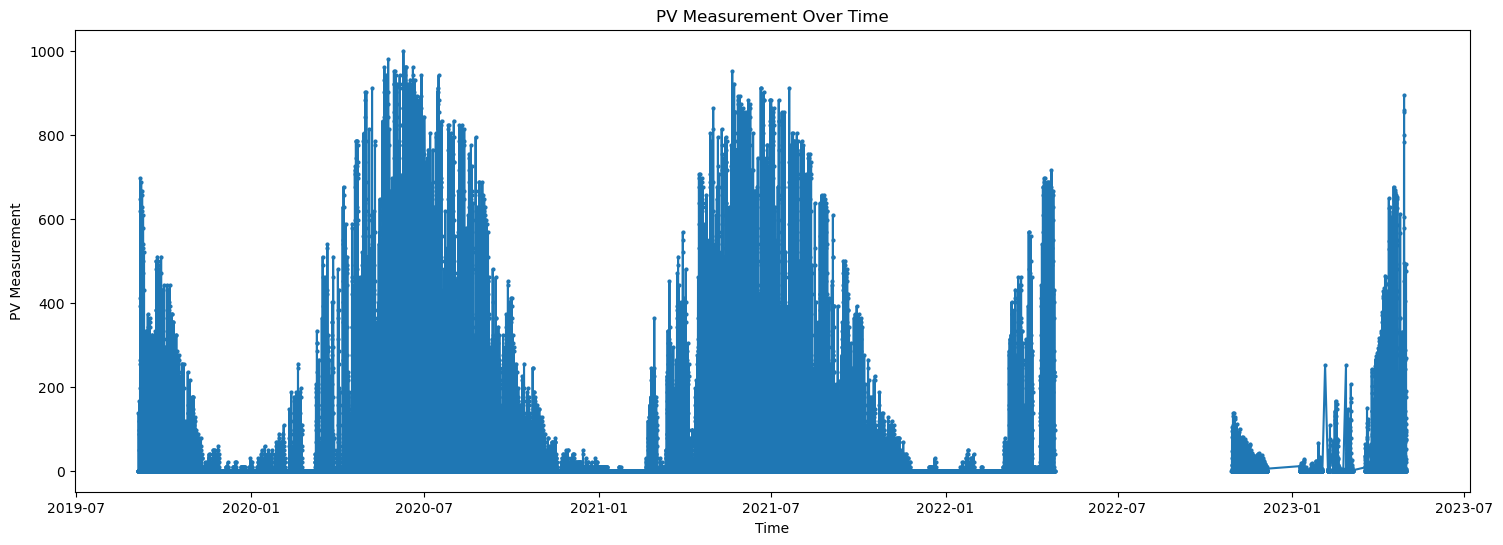

In [152]:

# Convert the time column to datetime format for better plotting
df['time'] = pd.to_datetime(df['time'])

# Plotting the data
plt.figure(figsize=(18, 6))
plt.plot(df['time'], df['pv_measurement'], marker='o', markersize=2, linestyle='-')
plt.title('PV Measurement Over Time')
plt.xlabel('Time')
plt.ylabel('PV Measurement')
plt.show()

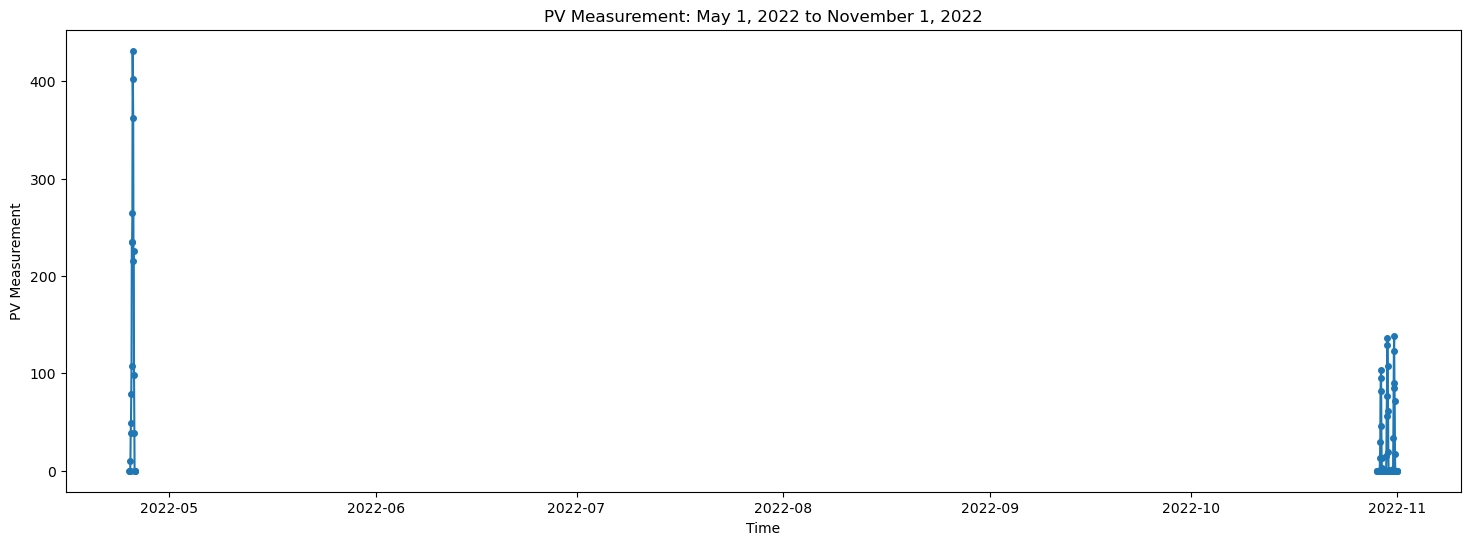

In [153]:
start_date = '2022-04-25'
end_date = '2022-11-01'
filtered_df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]

# Plotting the filtered data
plt.figure(figsize=(18, 6))
plt.plot(filtered_df['time'], filtered_df['pv_measurement'], marker='o', markersize=4, linestyle='-')
plt.title('PV Measurement: May 1, 2022 to November 1, 2022')
plt.xlabel('Time')
plt.ylabel('PV Measurement')
plt.show()

In [154]:
previous_df = pd.read_parquet('/Users/petterdalhaug/Documents/GitHub/data_analysis/analysis/data/A/train_targets.parquet')
previous_df['time'] = pd.to_datetime(previous_df['time'])


# Merge the two datasets on the "time" column to find overlapping time periods
merged_df = pd.merge(df, previous_df, on='time', how='inner', suffixes=('_current', '_previous'))

# Drop rows where any of the measurements are NaN
clean_merged_df = merged_df.dropna(subset=['pv_measurement_current', 'pv_measurement_previous'])

# Recalculate the Pearson correlation coefficient
correlation_coefficient_clean, _ = pearsonr(clean_merged_df['pv_measurement_current'], clean_merged_df['pv_measurement_previous'])

correlation_coefficient_clean

0.9099650995118853

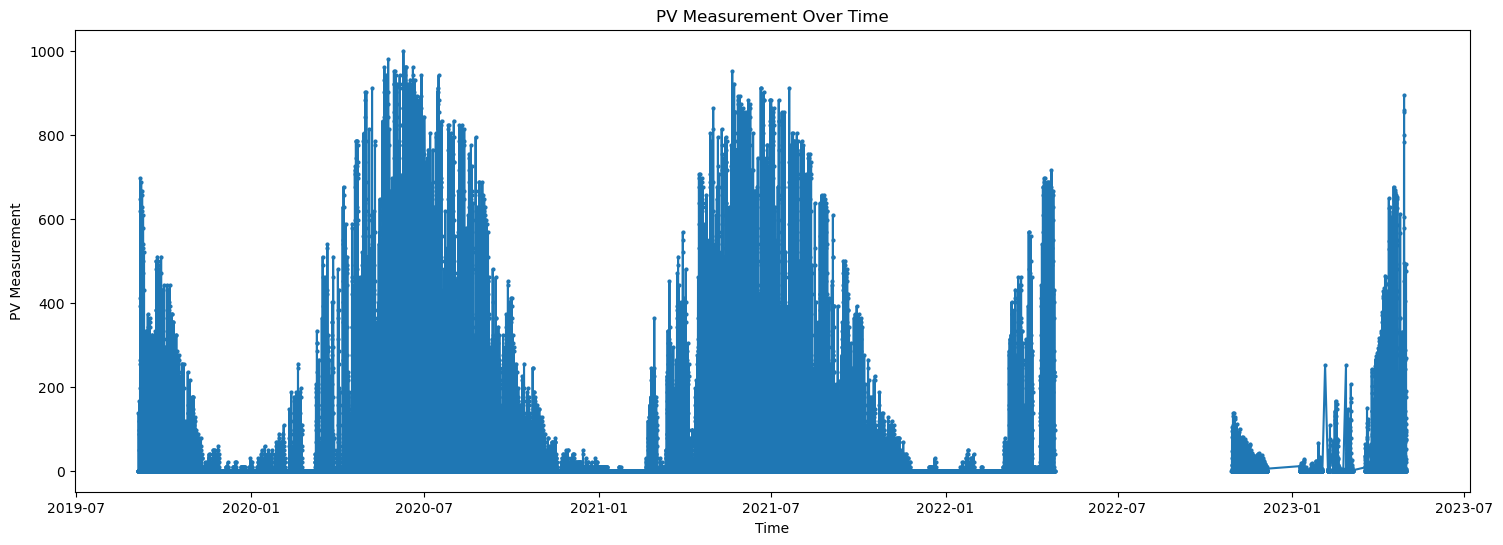

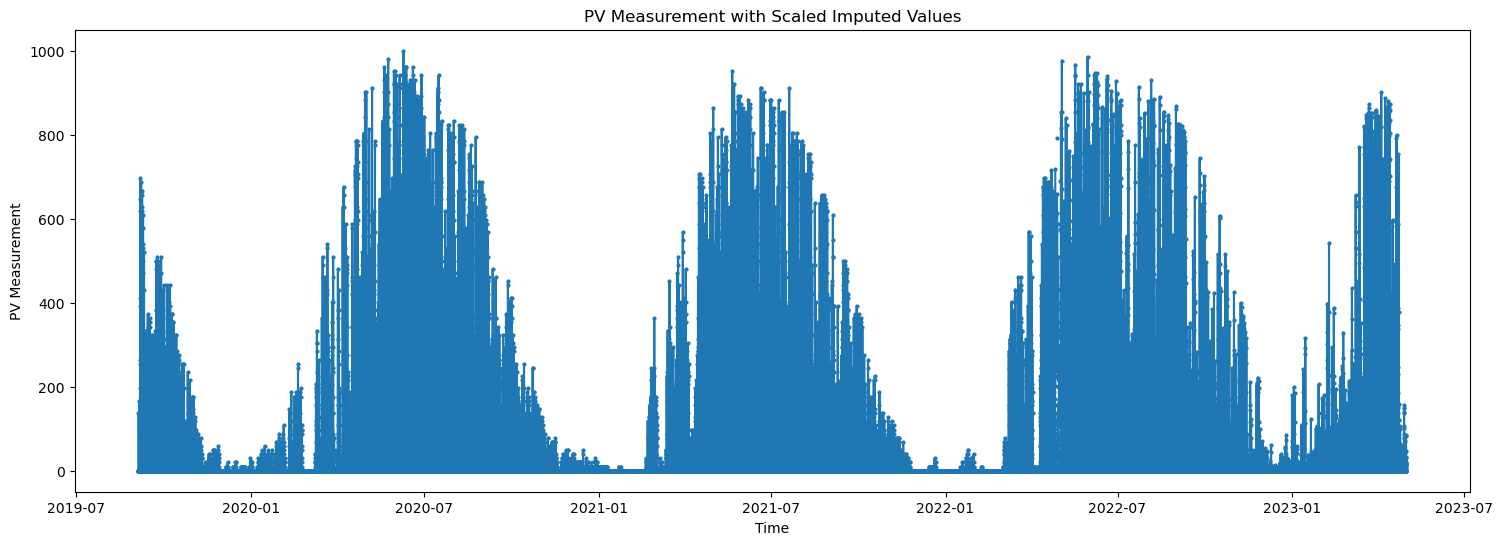

In [155]:
plt.figure(figsize=(18, 6))
plt.plot(df['time'], df['pv_measurement'], marker='o', markersize=2, linestyle='-')
plt.title('PV Measurement Over Time')
plt.xlabel('Time')
plt.ylabel('PV Measurement')
plt.show()

start_date = '2022-04-25'
end_date = '2023-07-01'

df = fill(start_date, end_date, previous_df, df)

In [156]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*30)
df = df.sort_index()

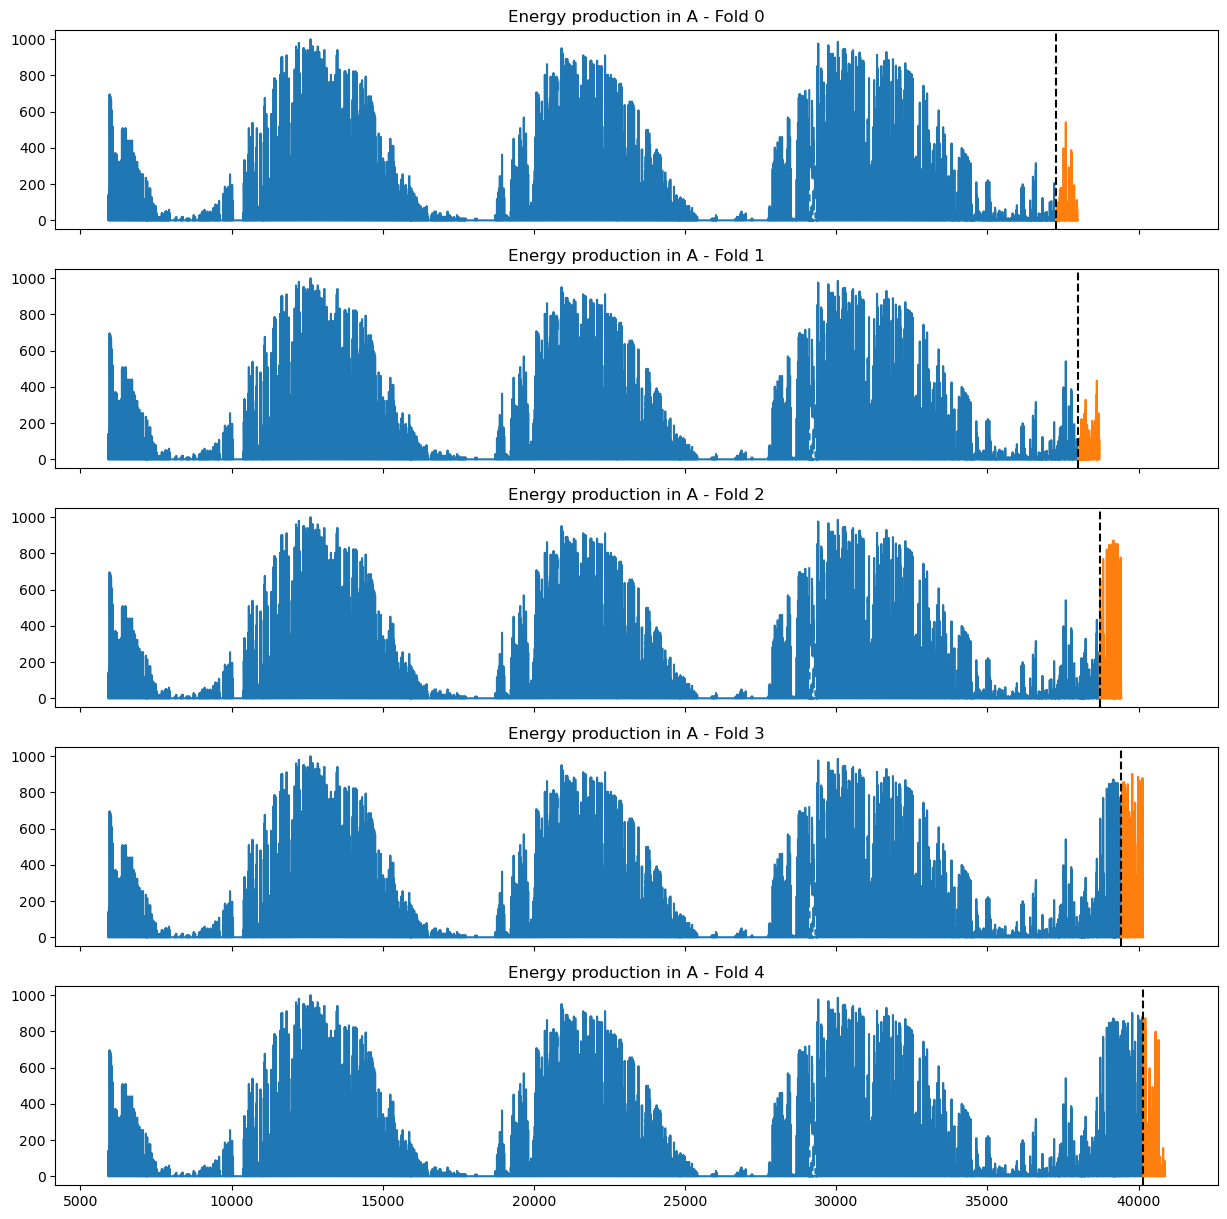

In [157]:
def time_series_split_and_plot(df, title):
    tss = TimeSeriesSplit(n_splits=5, test_size=24*30)
    df = df.sort_index()

    fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

    fold = 0
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]

        train['pv_measurement'].plot(ax=axs[fold],
                                     label='train', title=f'{title} - Fold {fold}')
        test['pv_measurement'].plot(ax=axs[fold], label='test')

        axs[fold].axvline(test.index.min(), color='black', linestyle='--')  
        fold += 1


# Apply TimeSeriesSplit and plot for each dataset
time_series_split_and_plot(df, 'Energy production in A')

In [158]:
X_train_observed = pd.read_parquet('/Users/petterdalhaug/Documents/GitHub/data_analysis/analysis/data/C/X_train_observed.parquet')
X_train_estimated = pd.read_parquet('/Users/petterdalhaug/Documents/GitHub/data_analysis/analysis/data/C/X_train_estimated.parquet')
train_targets = df

## Checking correlations after filling

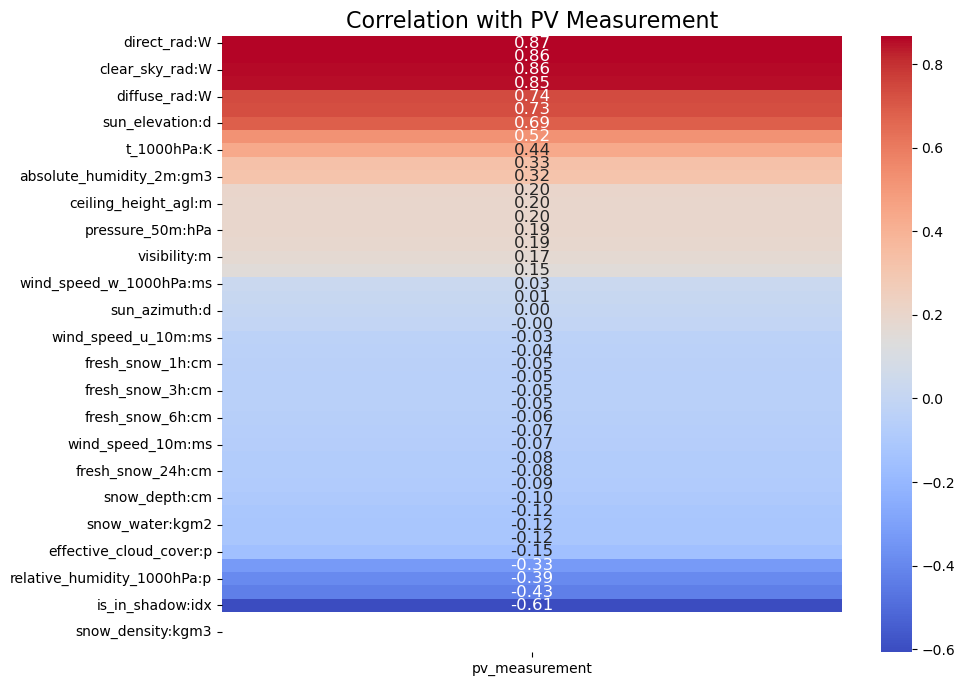

In [159]:
# Rename Columns
train_targets.rename(columns={'time': 'date_forecast'}, inplace=True)

# Align Time Intervals
X_train_observed_1hr = X_train_observed.groupby(pd.Grouper(key='date_forecast', freq='1H')).mean()

# Merge DataFrames
real_data = pd.merge(train_targets, X_train_observed_1hr.reset_index(), on='date_forecast')

# To fill NaN values with the mean
# Exclude constant features from the data before calculating correlation
filtered_real_data = real_data.drop(columns=[])

# Recalculate the correlation matrix
real_corr = filtered_real_data.corr()

# Filter to only include correlation with 'pv_measurement' and sort it
real_corr_with_target = real_corr[['pv_measurement']].sort_values(by='pv_measurement', ascending=False)

# Remove the 'pv_measurement' row to exclude the correlation of the target with itself
real_corr_with_target = real_corr_with_target.drop(index='pv_measurement')
# print(real_corr_with_target)
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(real_corr_with_target, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 12})
plt.title("Correlation with PV Measurement", fontsize=16)
plt.show()

In [160]:
df.to_csv('train_data_c.csv', index=False)